# Amazon Fine Food Reviews Analysis
-   Data is available on kaggle
- Resource used to do EDA: 
- https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/
### Details about Data: 
- This dataset consists of reviews of fine foods from amazon.
### How an Review Look Like
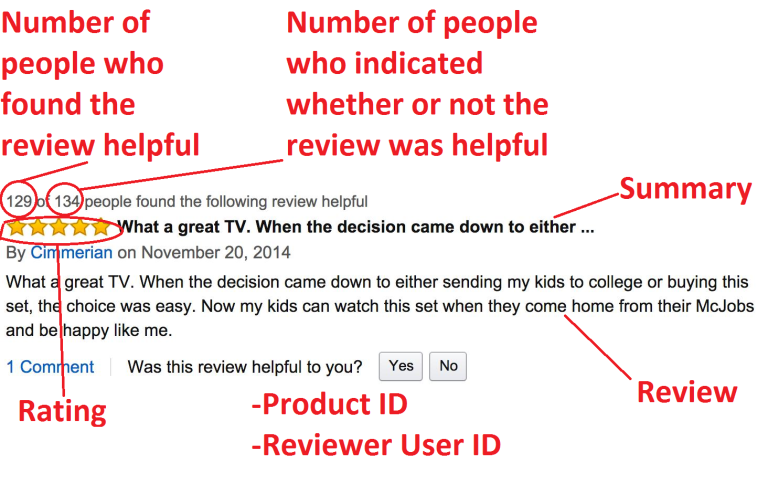

### Details about data 
- Reviews from Oct 1999 - Oct 2012
- 568,454 reviews
- 256,059 users
- 74,258 products
- 260 users with > 50 reviews
### Attributes
- Rating (1 - 5 stars)
- The review
- A summary of the review
- The number of people who have voted if this review is helpful or not.
- The number of people who have voted that the review is helpful.
- User ID
- Product ID
- Time - timestamp for the review

# What is Objective of This Analysis? 
- Given A review tell me weather a review is positive or negative
### How That will be Beneficial?
- This is an Business Intelligence Problem using this we can take many descision like if a product review from a distributor is very high then show them in top of search, other thing is if an distributor know the problem why he getting review or what are problem customer facing that can also be improved, also if review is positive and some of it element is most likely then producer will try to use that in his other product and many more thing this imformation can be used.

### As in Review No attribute is about polarity so how we define it?
- one such way is using the rating
- if rating is 1 or 2 mark it as -ve and if 4 or 5 mark as +ve
- there are other way as well but doing that reqire will take time and money
- how? let cluster the entire data in small group based on clustering algorithm and by reading a centroid of cluster if that review is +ve we mark entire as +ve and similarly for -ve as well but as it require human to do so i am not doing in this analysis

# Loading The Data
- In Kaggle there is option called "Add Data"
- Searched amazon fine food review and add it
### Code to Move it in working directory ("Can Be Used For Other Analysis as well")

In [1]:
# move to input directory
#%cd /kaggle/input/
#copy it from input to working directory
#!cp -r amazon-fine-food-reviews /kaggle/working
# that's it we can perform 
# cd to working directory
#%cd /kaggle/working/
# peform unzipping and all

# other to directly use it from if data is not in zip

# Python library using in this analysis

In [2]:
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import nltk.stem
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from bs4 import BeautifulSoup

from tqdm import tqdm
import os

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# load using sqlite data as csv is just using pd.read_csv()
con = sqlite3.connect('/kaggle/input/amazon-fine-food-reviews/database.sqlite') 
# take only review whose rating not equal to 3
data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""", con) 

### Covert the rating to polarity

In [4]:
def partition(x):
    if x < 3:
        return 0
    return 1

#change reviews with score less than 3 to be positive and vice-versa
Scores = data['Score']
polarity = Scores.map(partition) 
data['Score'] = polarity
print("Number of data points in our data", data.shape)
data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


# Apply Data Cleaning Techniques
- As There is no predefined approach or techinque to clean the data you have to used your common sense to do it like
- Remove Duplicate Reviews
- most of them are based on data used for processing and domain knowledge

In [5]:
# sometime in amazon a review for a product given is also assigned to other product 
# if the product is similar there are some in our dataset as well so remove them as well
# as this is known if we know how the review stored by amazon 
# To remove them sort them and check if there are review whose have same time same productid
# ans same text them remove them and only have its first instance
sData=data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
#data after data cleaning
cleanData=sData.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
cleanData.shape

(364173, 10)

In [6]:
# helpfull numerator = number of person found review to be helpful
# denominator = no of person review this product
# with this we know that no review with denominator > numerator
# see if there are any then remove it
cleanData=cleanData[cleanData.HelpfulnessNumerator<=cleanData.HelpfulnessDenominator]
cleanData.shape

(364171, 10)

# Feature Selection 
- As we know for this data set the main feature we can use to assign the polarity is text written by the customer 
- So The Main Feature to use for this analysis is Review Text

# Text Preprocessing
- As the machine are not able to process the words so apply techniques to convert the Review Text in vector
- Even Before that there are some Text Preprocessing : 
1. Removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. At Last Snowball Stemming the word (Convert the word with its root word)

In [7]:
# load the processed data already stored 
#cleanData=pd.read_csv('/kaggle/input/review/cleandata.csv')

In [8]:
#2.Remove the puntuations 
def remove_pun(sentence):
    cleaned=re.sub(r'[?|!|\|#|.|"|)|(|)|/|,|:|\'|-|$|+|~|;|-|_|@|>|<]',r' ',sentence)
    return cleaned
#3. Remove word which are not english letter
def remove_alhpa(sentence):
    cleaned=("\S*\d\S*", " ", sentence)
    return cleaned
# all english stop words
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])
# some phases in written short word 
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [9]:
sno=nltk.stem.SnowballStemmer('english')
# apply all the preprocessing
from tqdm import tqdm
# tqdm is for printing the status bar
preprocessed_reviews=[]
for sentence in tqdm(cleanData['Text'].values):
    #remove sentence if it has some hyper links
    sentence = re.sub(r"http\S+", "", sentence)
    # BeautifulSoup(sentance, 'lxml').get_text() removes all HTML and XML tags and returns
    #This is useful when you want to extract the human-readable content from a web page 
    # or any structured document.
    sentence = BeautifulSoup(sentence, 'lxml').get_text()
    #converting the pharases
    sentance = decontracted(sentence)
    #remove alha numeric
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    #convert every word in lower and take only if not in stop word and then snowball
    sentence = " ".join((sno.stem(e.lower())) for e in sentence.split() if e.lower() not in stopwords)
    # append the processed sentence to processed review
    preprocessed_reviews.append(remove_pun(sentence).strip())

  0%|          | 305/364171 [00:00<07:41, 788.73it/s] /tmp/ipykernel_20/480204129.py:12: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  sentence = BeautifulSoup(sentence, 'lxml').get_text()
100%|██████████| 364171/364171 [06:31<00:00, 930.91it/s]


In [10]:
#Perform sanity check that
# check for length
print(len(preprocessed_reviews))
#check any review
print(preprocessed_reviews[1500])



364171
great ingredi although  chicken 1st rather chicken broth  thing not think belong canola oil  canola rapese not somet dog would ever find natur find rapese natur eat it  would poison them  today food industri convinc mass canola oil safe even better oil oliv virgin coconut  fact though say otherwise  late 70 poison figur way fix that  still like could better


# Similary Preprocess the Summary of Review


In [11]:
preprocessed_Summary=[]
for sentence in tqdm(cleanData['Summary'].values):
    #remove sentence if it has some hyper links
    sentence = re.sub(r"http\S+", "", sentence)
    # BeautifulSoup(sentance, 'lxml').get_text() removes all HTML and XML tags and returns
    #This is useful when you want to extract the human-readable content from a web page 
    # or any structured document.
    sentence = BeautifulSoup(sentence, 'lxml').get_text()
    #converting the pharases
    sentance = decontracted(sentence)
    #remove alha numeric
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    #convert every word in lower and take only if not in stop word and then snowball
    sentence = ' '.join(sno.stem(e.lower()) for e in sentence.split() if e.lower() not in stopwords)
    # append the processed sentence to processed review
    preprocessed_Summary.append(sentence.strip())

  0%|          | 345/364171 [00:00<01:45, 3448.33it/s]/tmp/ipykernel_20/303607612.py:8: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  sentence = BeautifulSoup(sentence, 'lxml').get_text()
100%|██████████| 364171/364171 [01:50<00:00, 3297.44it/s]


In [12]:
#Perform sanity check that
# check for length
print(len(preprocessed_Summary))
#check any review
print(preprocessed_Summary[1500])

364171
would best canola oil left


In [13]:
# let replace this summary and review text 
cleanData['Text']=preprocessed_reviews
cleanData['Summary']=preprocessed_Summary

In [14]:
# store the processed and clean data and read next time for further operation
#cleanData.to_csv('cleandata.csv',index=False)# if store like csv file
#cleanData.to_sql('review', con, if_exists='replace', index=False) # if store in sql

# Featurization/Text Processing:
- Since the word can't be processed by the machine convert it to the vector 
- There are various Algorithm to perform the text processing

# 1. Using Bag of Words
- This is an one of the easiest way to convert text to vector.
- It says that find the all unique word in the text corpus  and form an vector for all the words.After that to convert an review to vector to take a vector of size of the (words in corpus) for each cell in the vector filled with the frequecny of word appear in the review.
### How the similarity of review will be? 
- It says that find the difference b/w two vector and if that difference is less then they are similar if its more then they are dissimilar. 

In [15]:
# i will be using only 50000 review for this analysis
#cleanData=pd.read_csv('/kaggle/input/review/cleandata.csv')

In [16]:
#BoW
count_vect = CountVectorizer() #in scikit-learn that do as above description
# for bag of words taking only 10000 reviews
count_vect.fit(preprocessed_reviews[:10000])
print("Words in Corpus ", count_vect.get_feature_names_out()[:10])

final_counts = count_vect.transform(preprocessed_reviews[:10000])
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

Words in Corpus  ['00' '000' '000su' '00am' '00pm' '01' '02' '025' '03' '030']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (10000, 21376)
the number of unique words  21376


### Problem with BoW:
1. It doesn't take an considration into the symentic maening of words (some time even though the review are not related to each other but because of the way the bag of word work they mark them as related. 
2. since it consider the all unique word vector for each review it would be an sparse vector. which means wastage of space. that's because lots of words that not play much role to define an sentence they also as an considration.
3. One more problem specific to unigram is some there are word that has the combine meaning will be lost.

### How To Over Come with All These Problem:
- It is suggested to to preprocess as done above like removing punctuation ,stemming , lemitization ....
- solution to 3rd problem is to use n-grams and <b>THERE IS FACT ABOUT THE BAG OF WORDS IS? IT WORK MORE USEFUL WITH THE BI-GRAM OR TRI-GRAM.</b>

## Perform n-gram (bi ot tri gram) by passing the n_range(2,3) in countvectorizer


In [17]:
#BoW
count_bi_vect = CountVectorizer(ngram_range=(2,3),min_df=10, max_features=5000) 
#in scikit-learn that do as above description
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)

print("Words in Corpus ", count_vect.get_feature_names_out()[:10])
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

Words in Corpus  ['00' '000' '0000' '000001' '00001' '000013' '0000soo' '000111052bulk'
 '0001bottl' '0003']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (364171, 119480)
the number of unique words including both unigrams and bigrams  119480


### Even n-gram had problem that it can't take symentaic meaning of word into the considration.

# 2. Using TF-IDF
- TF -> Term Frequency (how offten a word appear in the review).
- to calculate TF do for each cell in vector computed as (number of time word appear in the review/total number of word in review).
- IDF -> Inverse Document frequency (this is define for a word in corpus).
- to compute idf = log(number of document or corpus/number of time a word appear in entire corpus).
### How this Tf-Idf works?
- This is same as the bow only difference is insted placing the count of word place the product of term frequency(word in review) and idf(word,document).

- TF(t, d) = (Number of occurrences of term t in document d) / (Total number of terms in document d)
- IDF(t, D) = log((Total number of documents D) / (Number of documents containing term t))
- TF-IDF(t, d, D) = TF(t, d) * IDF(t, D)

- In order to compute idf log is used one of reason is zipf's law: it says that the frequency of word occur in english is follows the pareto or power law distriution so as we know if we take of powerlaw we will have the normal distribution.
- also it found by many experiment that it works well

### even After that it does not take count on semantic meaning  of the problem.
- one thing to notice that it uses the dense matrix so used only 50000 review only

In [18]:
#tfidf
tfReview=preprocessed_reviews[:10000]
tifd=TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf=tifd.fit_transform(tfReview)

print("some sample features(unique words in the corpus)",tifd.get_feature_names_out()[0:10])
print("the type of count vectorizer ",type(tf))
print("the shape of out text TFIDF vectorizer ",tf.get_shape())
print("the number of unique words including both unigrams and bigrams ", tf.get_shape()[1])

some sample features(unique words in the corpus) ['00' '000' '10' '10 minut' '10 minutes' '10 year' '10 years' '100'
 '100 kona' '11']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (10000, 6582)
the number of unique words including both unigrams and bigrams  6582


# 3. Word2Vec
- As we know the problem of tf-idf and other algorithm is they not care about the semantic meaning in considration while creating vector of given text so to solve that there is model develop by google that create an 300 dimension of vector for each word and it automatically take the considration of the semantic meaning to create vector like it inhebit the relationship as the human being have like if we take distance between the vectors of word "Male" and "Female" will same as the difference in "King" and "Queen" , "Boy" and "Girl" ..... also there are various relation like state and country and many more


In [19]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [20]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=True
#train using our own corpus 
want_to_use_google_w2v = True
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('fantast', 0.8469179272651672), ('excel', 0.8371660709381104), ('awesom', 0.8345046639442444), ('terrif', 0.7933550477027893), ('good', 0.7876808643341064), ('wonder', 0.7392159700393677), ('fabul', 0.7127750515937805), ('fantastic', 0.7025330066680908), ('nice', 0.689254641532898), ('wonderful', 0.6774102449417114)]
[('nastiest', 0.8214808106422424), ('greatest', 0.6934630870819092), ('best', 0.6828958988189697), ('disgust', 0.6589768528938293), ('wors', 0.6576260924339294), ('tastiest', 0.6339185833930969), ('worst-tast', 0.6331034302711487), ('saltiest', 0.630035400390625), ('best-tast', 0.6267790794372559), ('sweetest', 0.6129727959632874)]


In [21]:
w2v_words = list(w2v_model.wv.index_to_key)


- so the word to vec return the vector for every word but in review there are sentences so how can we convert the sentences to the vector
- There are vaious ways to do like
# 1. Converting text into vectors using wAvg W2V

In [22]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 364171/364171 [14:14<00:00, 426.11it/s]

364171
100


In [23]:
print(len(sent_vectors[0]))

100


# 2. Converting text into vectors using TFIDF weighted W2v

In [24]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
model.fit(preprocessed_reviews[:50000])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names_out(), list(model.idf_)))
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names_out() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance[:50000]): # for each review/sentence 
    sent_vec = np.zeros(100) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 50000/50000 [39:29<00:00, 21.10it/s]


# Applying TNSE on Text BOW vectors
- please write all the code with proper documentation, and proper titles for each subsection
- when you plot any graph make sure you use 
    - a. Title, that describes your plot, this will be very helpful to the reader
    - b. Legends if needed
    - c. X-axis label
    - d. Y-axis label

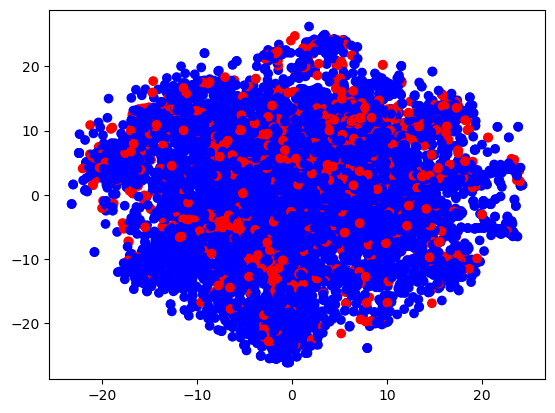

In [25]:
# https://github.com/pavlin-policar/fastTSNE you can try this also, this version is little faster than sklearn 
import numpy as np
from sklearn.manifold import TSNE
import pandas as pd
import matplotlib.pyplot as plt

x = final_counts
y = np.array(cleanData['Score'][:10000])

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)

X_embedding = tsne.fit_transform(x.toarray())
# if x is a sparse matrix you need to pass it as X_embedding = tsne.fit_transform(x.toarray()) , .toarray() will convert the sparse matrix into dense matrix

for_tsne = np.hstack((X_embedding, y.reshape(-1,1)))
for_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dimension_x','Dimension_y','Score'])
colors = {0:'red', 1:'blue'}
plt.scatter(for_tsne_df['Dimension_x'], for_tsne_df['Dimension_y'], c=for_tsne_df['Score'].apply(lambda x: colors[x]))
plt.show()

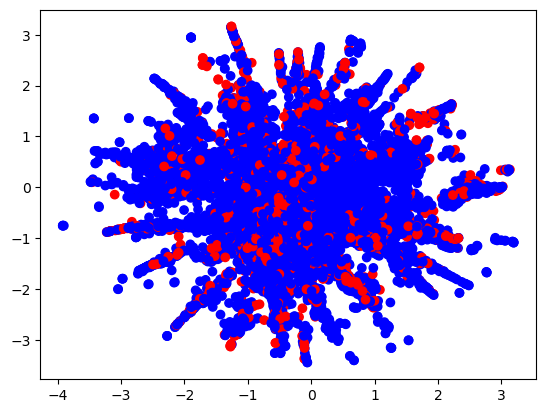

In [26]:
# https://github.com/pavlin-policar/fastTSNE you can try this also, this version is little faster than sklearn 
import numpy as np
from sklearn.manifold import TSNE
import pandas as pd
import matplotlib.pyplot as plt

x = tf
y = np.array(cleanData['Score'][:10000])

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)

X_embedding = tsne.fit_transform(x.toarray())
# if x is a sparse matrix you need to pass it as X_embedding = tsne.fit_transform(x.toarray()) , .toarray() will convert the sparse matrix into dense matrix

for_tsne = np.hstack((X_embedding, y.reshape(-1,1)))
for_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dimension_x','Dimension_y','Score'])
colors = {0:'red', 1:'blue'}
plt.scatter(for_tsne_df['Dimension_x'], for_tsne_df['Dimension_y'], c=for_tsne_df['Score'].apply(lambda x: colors[x]))
plt.show()

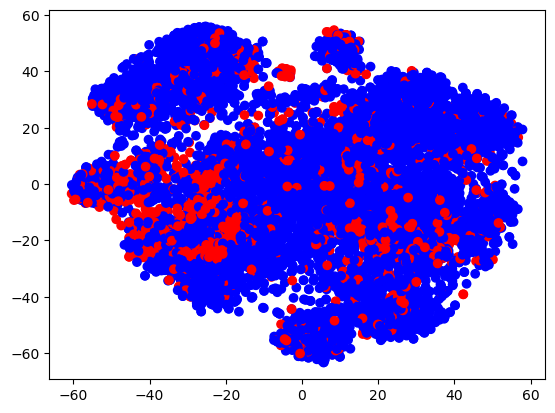

In [27]:
# https://github.com/pavlin-policar/fastTSNE you can try this also, this version is little faster than sklearn 
import numpy as np
from sklearn.manifold import TSNE
import pandas as pd
import matplotlib.pyplot as plt

x = np.array(sent_vectors[:10000])
y = np.array(cleanData['Score'][:10000])

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)

X_embedding = tsne.fit_transform(x)
# if x is a sparse matrix you need to pass it as X_embedding = tsne.fit_transform(x.toarray()) , .toarray() will convert the sparse matrix into dense matrix

for_tsne = np.hstack((X_embedding, y.reshape(-1,1)))
for_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dimension_x','Dimension_y','Score'])
colors = {0:'red', 1:'blue'}
plt.scatter(for_tsne_df['Dimension_x'], for_tsne_df['Dimension_y'], c=for_tsne_df['Score'].apply(lambda x: colors[x]))
plt.show()

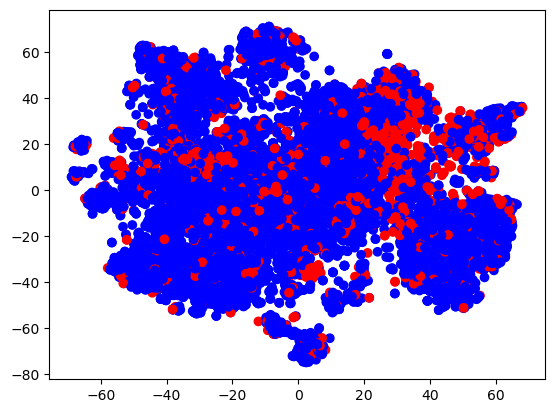

In [28]:
# https://github.com/pavlin-policar/fastTSNE you can try this also, this version is little faster than sklearn 
import numpy as np
from sklearn.manifold import TSNE
import pandas as pd
import matplotlib.pyplot as plt

x = np.array(tfidf_sent_vectors[:10000])
y = np.array(cleanData['Score'][:10000])

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)

X_embedding = tsne.fit_transform(x)
# if x is a sparse matrix you need to pass it as X_embedding = tsne.fit_transform(x.toarray()) , .toarray() will convert the sparse matrix into dense matrix

for_tsne = np.hstack((X_embedding, y.reshape(-1,1)))
for_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dimension_x','Dimension_y','Score'])
colors = {0:'red', 1:'blue'}
plt.scatter(for_tsne_df['Dimension_x'], for_tsne_df['Dimension_y'], c=for_tsne_df['Score'].apply(lambda x: colors[x]))
plt.show()